##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## RandBits MNIST using Contrastive Learning.

This notebook trains an unsupervised model on the RandBits MNIST dataset using contrastive learning, similar to the results shown in Figure 5(a) in ***Intriguing Properties of Contrastive Losses***.

In [9]:
#@title Imports.
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd

In [3]:
#@title Data preprocessing.
def random_crop_and_resize(image):
  sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
      image_size=tf.shape(image),
      bounding_boxes=tf.constant(
          [0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4]),
      min_object_covered=0.1,
      aspect_ratio_range=(3. / 4, 4. / 3.),
      area_range=(0.5, 1.0),
      max_attempts=100,
      use_image_if_no_bounding_boxes=True)
  bbox_begin, bbox_size, _ = sample_distorted_bounding_box

  # Crop the image to the specified bounding box.
  offset_y, offset_x, _ = tf.unstack(bbox_begin)
  target_height, target_width, _ = tf.unstack(bbox_size)
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, target_height, target_width)

  return tf.image.resize(image, [28, 28], method=tf.image.ResizeMethod.BILINEAR)

def hash_image_to_bits(image, extra_channel_bits):
  hash = tf.compat.v1.strings.to_hash_bucket_fast(
      tf.image.encode_jpeg(image),
      num_buckets=2**extra_channel_bits)
  bits = tf.cast(
      tf.math.mod(
            tf.bitwise.right_shift(tf.expand_dims([hash], 1),
            tf.range(extra_channel_bits, dtype=tf.int64)), 2),
      tf.float32)
  return bits

def pack_extra_channels(image, bits):
  extra_channel_bits = tf.shape(bits)[-1]
  bits = tf.broadcast_to(bits, [28, 28, extra_channel_bits])
  return tf.concat([image, tf.cast(bits, tf.float32)], axis=-1)

def get_process_fns(extra_channel_bits):
  def preprocess_train_fn(image, label):
    bits = hash_image_to_bits(image, extra_channel_bits)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    label = tf.cast(label, tf.int32)

    image_a = random_crop_and_resize(image)
    image_b = random_crop_and_resize(image)

    # Pack extra channels.
    if extra_channel_bits > 0:
      image_a = pack_extra_channels(image_a, bits)
      image_b = pack_extra_channels(image_b, bits)

    image = tf.stack([image_a, image_b], axis=0)  # [2, h, w, c]
    return (image, label)

  def preprocess_eval_fn(image, label):
    bits = hash_image_to_bits(image, extra_channel_bits)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    label = tf.cast(label, tf.int32)
    if extra_channel_bits > 0:
      image = pack_extra_channels(image, bits)
    return (image, label)

  return preprocess_train_fn, preprocess_eval_fn

In [4]:
#@title Objective functions.
cls_loss_object = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    reduction=tf.keras.losses.Reduction.NONE)

def get_cls_loss(labels, outputs):
  return tf.reduce_mean(cls_loss_object(labels, outputs))

def get_contrastive_loss(z1, z2, nt_xent_temp):   # [batch_size, dim]
  batch_size = tf.shape(z1)[0]
  dim = tf.shape(z1)[1]

  z1 = tf.math.l2_normalize(z1, -1)
  z2 = tf.math.l2_normalize(z2, -1)

  sim = tf.matmul(z1, z2, transpose_b=True)  # [batch_size, batch_size]
  sim /= nt_xent_temp

  labels = tf.eye(batch_size)

  loss = (
      get_cls_loss(labels, sim) +
      get_cls_loss(labels, tf.transpose(sim))
  )
  return tf.reduce_mean(loss), sim

In [5]:
#@title Model.
def dense_bn_relu(units):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          units, use_bias=False,
          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
      tf.keras.layers.BatchNormalization(center=True, scale=True),
      tf.keras.layers.ReLU()
  ])

def conv2d_bn_relu(filters, kernel_size, strides):
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          filters, kernel_size, strides, use_bias=False,
          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
      tf.keras.layers.BatchNormalization(center=True, scale=True),
      tf.keras.layers.ReLU()
  ])

class ConvN(tf.keras.Model):

  def __init__(self, width_multiplier):
    super(ConvN, self).__init__()
    self.num_classes = 10
    self.latent_dim = 128 * width_multiplier
    self.proj_dim = self.latent_dim / 2

    self.enc = tf.keras.Sequential([
        conv2d_bn_relu(32 * width_multiplier, 3, 2),
        conv2d_bn_relu(64 * width_multiplier, 3, 2),
        conv2d_bn_relu(64 * width_multiplier, 3, 2),
        tf.keras.layers.Flatten(),
        dense_bn_relu(self.latent_dim)
    ])

    self.proj = tf.keras.Sequential([
        dense_bn_relu(self.latent_dim * 2),
        tf.keras.layers.Dense(
            self.proj_dim, use_bias=False, activation=None,
            kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    ])

    self.classifier = tf.keras.layers.Dense(self.num_classes)

  def call(self, inputs, training):
    y = self.enc(inputs, training)
    z = self.proj(y, training)
    pred = self.classifier(tf.stop_gradient(y))
    return y, z, pred

In [6]:
#@title Define train_and_eval() for contrastive learning.
def train_and_eval(
    batch_size=128,
    width_multiplier=1,
    extra_channel_bits=10,
    nt_xent_temp=0.1,
    learning_rate=0.001,
    epochs=10,
    log_summary_every_n_steps=100,
    eval_every_n_steps=100,
    print_output=False):
  strategy = tf.distribute.MirroredStrategy()

  # Load dataset.
  builder = tfds.builder('mnist')
  builder.download_and_prepare()

  preprocess_train_fn, preprocess_eval_fn = get_process_fns(extra_channel_bits)
  train_dataset = builder.as_dataset(split='train', as_supervised=True)
  train_dataset = train_dataset.repeat().map(preprocess_train_fn)
  train_dataset = train_dataset.batch(batch_size)

  test_dataset = builder.as_dataset(split='test', as_supervised=True)
  test_dataset = test_dataset.map(preprocess_eval_fn)
  test_dataset = test_dataset.batch(batch_size, drop_remainder=False)

  train_iter = iter(train_dataset)
  total_steps = int(60000 * epochs / batch_size)
  steps_per_epoch_test = math.ceil(10000 / batch_size)

  # Model and optimizer.
  model = ConvN(width_multiplier)
  global_step = tf.Variable(
      1, trainable=False, name="global_step", dtype=tf.int64)

  lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=learning_rate,
      decay_steps=total_steps,
      end_learning_rate=0.)
  optimizer = tf.keras.optimizers.Adam(lr_schedule)

  # Define metrics.
  loss_metrics = [
      "train_classification_loss",
      "train_contrastive_loss",
      "train_total_loss",
  ]
  acc_metrics = ["train_accuracy", "eval_accuracy",
                 "train_contrastive_accuracy"]
  metric_list = {s: tf.keras.metrics.Mean(name=s) for s in loss_metrics}
  metric_list.update({
      s: tf.keras.metrics.SparseCategoricalAccuracy(name=s)
      for s in acc_metrics
  })

  # Step functions.
  @tf.function
  def train_step(iterator):
    def step_fn(inputs):
      images, labels = inputs
      labels_one_hot = tf.one_hot(labels, depth=10)
      images_a, images_b = tf.unstack(images, num=2, axis=1)

      with tf.GradientTape() as tape:
        _, za, pred_a = model(images_a, training=True)
        _, zb, pred_b = model(images_b, training=True)

        contrastive_loss, contrastive_sim = (
            get_contrastive_loss(za, zb, nt_xent_temp))
        classifier_loss = get_cls_loss(labels_one_hot, pred_a)
        wd_loss = sum(model.losses)
        loss = classifier_loss + wd_loss + contrastive_loss

        batch_size = tf.shape(images)[0]
        metric_list["train_contrastive_loss"].update_state(contrastive_loss)
        metric_list["train_classification_loss"].update_state(classifier_loss)
        metric_list["train_accuracy"].update_state(labels, pred_a)
        metric_list["train_contrastive_accuracy"].update_state(
            tf.range(batch_size), contrastive_sim)
        metric_list["train_total_loss"].update_state(loss)

      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    strategy.run(step_fn, args=(next(iterator),))
    global_step.assign_add(1)

  @tf.function
  def eval_step(iterator):
    def step_fn(inputs):
      images, labels = inputs
      _, _, predictions = model(images, training=False)
      metric_list["eval_accuracy"].update_state(labels, predictions)
    strategy.run(step_fn, args=(next(iterator),))

  # Train and eval loop.
  steps = []
  eval_accuracies = []
  while global_step.numpy() <= total_steps:
    train_step(train_iter)
    step = global_step.numpy()

    if step % log_summary_every_n_steps == 0:
      log_msg = "Steps: {}".format(step)
      for m in loss_metrics + acc_metrics:
        if m.startswith("train"):
          log_msg += ", {}: {}".format(m, metric_list[m].result())
          metric_list[m].reset_states()
      if print_output:
        print(log_msg)

    if (step % eval_every_n_steps == 0) or (step == total_steps):
      eval_iter = iter(test_dataset)

      for m in loss_metrics + acc_metrics:
        if m.startswith("eval"):
          metric_list[m].reset_states()

      for _ in range(steps_per_epoch_test):
        eval_step(eval_iter)
      if print_output:
        print("Steps: {}, Test accuracy: {}".format(
            step, metric_list["eval_accuracy"].result()))
      steps.append(step)
      eval_accuracies.append(metric_list["eval_accuracy"].result())

  return steps, eval_accuracies

In [7]:
# The actual training. This cell takes a long time to run, especially on a CPU.
rows = []
cols = ['extra_channel_bits', 'nt_xent_temp', 'eval_accuracy']
for temp in [0.05, 0.1, 0.2]:
  for bits in [0, 5, 10, 15, 20]:
    steps, accuracies = train_and_eval(
        batch_size=1000,
        width_multiplier=1,
        extra_channel_bits=bits,
        nt_xent_temp=temp,
        learning_rate=0.001,
        epochs=10,
        eval_every_n_steps=1000,
        print_output=False)
    rows.append([bits, temp, accuracies[-1].numpy()])
    print("extra_channel_bits={}, nt_xent_temp={}, eval_accuracy={}".format(
        bits, temp, accuracies[-1]))
plot_df = pd.DataFrame.from_records(rows, columns=cols)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


extra_channel_bits=0, nt_xent_temp=0.05, eval_accuracy=0.8992000222206116


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


extra_channel_bits=5, nt_xent_temp=0.05, eval_accuracy=0.7063000202178955


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


extra_channel_bits=10, nt_xent_temp=0.05, eval_accuracy=0.32989999651908875


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


extra_channel_bits=15, nt_xent_temp=0.05, eval_accuracy=0.14259999990463257


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


extra_channel_bits=20, nt_xent_temp=0.05, eval_accuracy=0.0989999994635582


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


extra_channel_bits=0, nt_xent_temp=0.1, eval_accuracy=0.8916000127792358


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


extra_channel_bits=5, nt_xent_temp=0.1, eval_accuracy=0.6118000149726868


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


extra_channel_bits=10, nt_xent_temp=0.1, eval_accuracy=0.1867000013589859


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


extra_channel_bits=15, nt_xent_temp=0.1, eval_accuracy=0.09799999743700027


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


extra_channel_bits=20, nt_xent_temp=0.1, eval_accuracy=0.10329999774694443


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


extra_channel_bits=0, nt_xent_temp=0.2, eval_accuracy=0.8998000025749207


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


extra_channel_bits=5, nt_xent_temp=0.2, eval_accuracy=0.32989999651908875


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


extra_channel_bits=10, nt_xent_temp=0.2, eval_accuracy=0.10350000113248825


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


extra_channel_bits=15, nt_xent_temp=0.2, eval_accuracy=0.10029999911785126


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


extra_channel_bits=20, nt_xent_temp=0.2, eval_accuracy=0.09889999777078629


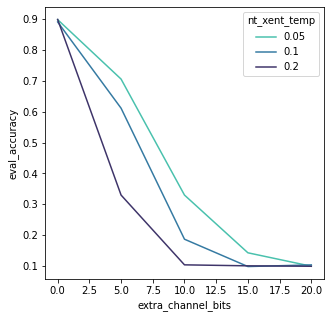

In [8]:
plt.figure(figsize=(5, 5))
sns.lineplot(
    x='extra_channel_bits', y='eval_accuracy', hue='nt_xent_temp',
    data=plot_df, palette=sns.color_palette("mako_r", 3))